# 第8章 ベイズ推定：データを元に「確信」を高める手法

## 「08-bayes_regression.py」の解説

ITエンジニアための機械学習理論入門「第8章 ベイズ推定:データを元に「確信」を高める手法」で使用しているサンプルコード「08-bayes_regression.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

関数 normal、 multivariate_normal は、1次元、および、多次元の正規分布に従う乱数を生成するために利用します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal, multivariate_normal

正弦関数に正規分布のノイズを載せたデータセットを生成する関数を定義します。

これは、0≦x≦1 の区間を等分した num 個の点 x に対して、対応する y の値を生成します。

In [2]:
# データセット {x_n,y_n} (n=1...num) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

例として、4個のデータをトレーニングセットとして生成します。

In [3]:
train_set = create_dataset(4)
train_set

,x,y
0,0.000000,-0.056999
1,0.333333,0.909071
2,0.666667,-0.855983
3,1.000000,0.262611


ベイズ推定の計算結果を返す関数を用意します。

これは、以下の値を返します。

* 点 x の予測分布（正規分布）の平均 m(x)
* 点 x の予測分布（正規分布）の標準偏差 s(x)
* 係数 w の事後分布（多次元正規分布）の平均ベクトル
* 係数 w の事後分布（多次元正規分布）の分散共分散行列

In [4]:
# 事後分布に基づく推定曲線、および、事後分布の平均と分散を計算
def resolve(dataset, m):
    beta = 1.0/(0.3)**2 # 真の分布の分散
    alpha = 1.0/100**2  # 事前分布の分散
    t = dataset.y
    phis = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phis = pd.concat([phis,p], axis=1)

    for index, line in phis.iterrows():
        phi = DataFrame(line)
        if index == 0:
            phiphi = np.dot(phi,phi.T)
        else:
            phiphi += np.dot(phi,phi.T)
    s_inv = alpha * DataFrame(np.identity(m+1)) + beta * phiphi
    s = np.linalg.inv(s_inv) # 係数 w の事後分布の分散共分散行列

    # 点 x の予測分布の平均 m(x)
    def mean_fun(x0):
        phi_x0 = DataFrame([x0 ** i for i in range(0,m+1)])
        for index, line in phis.iterrows():
            if index == 0:
                tmp = t[index] * line
            else:
                tmp += t[index] * line
        return (beta * np.dot(np.dot(phi_x0.T, s), DataFrame(tmp))).flatten()

    # 点 x の予測分布の標準偏差 s(x)
    def deviation_fun(x0):
        phi_x0 = DataFrame([x0 ** i for i in range(0,m+1)])
        deviation = np.sqrt(1.0/beta + np.dot(np.dot(phi_x0.T, s), phi_x0))
        return deviation.diagonal()

    for index, line in phis.iterrows():
        if index == 0:
            tmp = t[index] * line
        else:
            tmp += t[index] * line
    mean = beta * np.dot(s, DataFrame(tmp)).flatten() # 係数 w の事後分布の平均

    return mean_fun, deviation_fun, mean, s

先ほどの関数を利用して、ベイズ推定の結果から予測されるデータ分布（次に観測されるデータの分布）をグラフ表示する関数を用意します。

In [5]:
def show_estimation(subplot, train_set, order):
        mean_fun, deviation_fun, mean, sigma = resolve(train_set, order)
        num = len(train_set)
        
        subplot.set_xlim(-0.05,1.05)
        subplot.set_ylim(-2,2)
        subplot.set_title("N=%d" % num)

        # トレーニングセットを表示
        subplot.scatter(train_set.x, train_set.y, marker='o', color='blue',
                        label=None)

        linex = np.arange(0,1.01,0.01)

        # 真の曲線を表示
        liney = np.sin(2*np.pi*linex)
        subplot.plot(linex, liney, color='green',linestyle=':')

        # 平均と標準偏差の曲線を表示
        m = np.array(mean_fun(linex))
        d = np.array(deviation_fun(linex))
        subplot.plot(linex, m, color='red', label='mean')
        subplot.legend(loc=1)
        subplot.plot(linex, m-d, color='black', linestyle='--')
        subplot.plot(linex, m+d, color='black', linestyle='--')

実際にグラフを描いてみます。

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


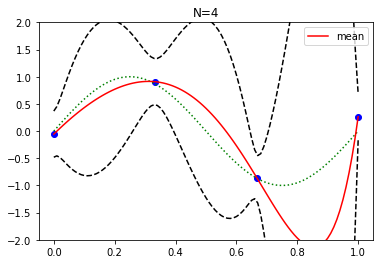

In [6]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
show_estimation(subplot, train_set, 9)

事後分布に従って得られる係数のサンプルを取得して、多項式のサンプルを表示する関数を用意します。

4種類のサンプルを取得してグラフを描きます。

In [7]:
def show_samples(subplot, train_set, order):
        mean_fun, deviation_fun, mean, sigma = resolve(train_set, order)
        num = len(train_set)
        ws_samples = DataFrame(multivariate_normal(mean,sigma,4))
        
        subplot.set_xlim(-0.05,1.05)
        subplot.set_ylim(-2,2)
        subplot.set_title("N=%d" % num)

        # トレーニングセットを表示
        subplot.scatter(train_set.x, train_set.y, marker='o', color='blue',
                        label=None)

        linex = np.arange(0,1.01,0.01)

        # 真の曲線を表示
        liney = np.sin(2*np.pi*linex)
        subplot.plot(linex, liney, color='green',linestyle=':')

        # 多項式のサンプルを表示
        m = np.array(mean_fun(linex))
        d = np.array(deviation_fun(linex))
        liney = m
        subplot.plot(linex, liney, color='red', label="mean")
        subplot.legend(loc=1)
        
        def f(x, ws):
            y = 0
            for i, w in enumerate(ws):
                y += w * (x ** i)
            return y

        for index, ws in ws_samples.iterrows():
            liney = f(linex, ws)
            subplot.plot(linex, liney, color='red', linestyle='--')

実際に多項式のサンプルを描いてみます。

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


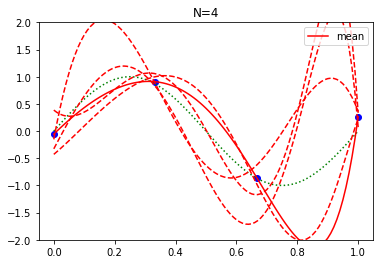

In [8]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
show_samples(subplot, train_set, 9)

データの数を変化させながら、それぞれのグラフを並べて描きます。

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


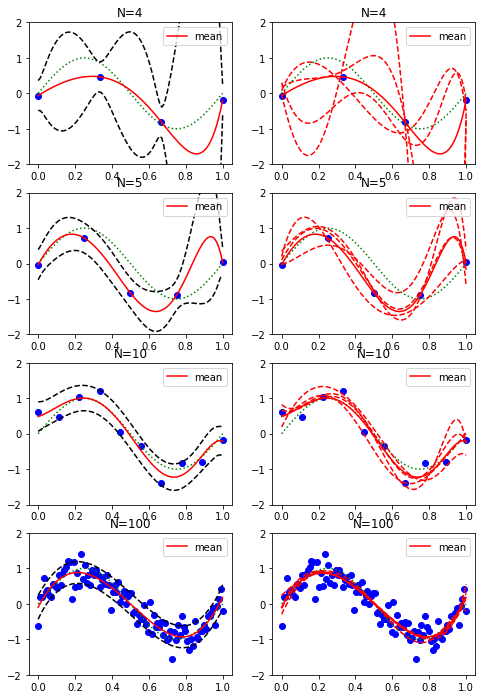

In [9]:
fig = plt.figure(figsize=(8, 12))
i = 1
for num in [4,5,10,100]:
    train_set = create_dataset(num)
    subplot1 = fig.add_subplot(4,2,i)
    subplot2 = fig.add_subplot(4,2,i+1)
    show_estimation(subplot1, train_set, 9)
    show_samples(subplot2, train_set, 9)
    i += 2